# Multi-Class Model for Rice Varieties Identification Using Python and Scikit-Learn
### David Lowe
### March 7, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Rice Varieties Identification dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The dataset owner collected 75,000 pieces of rice grain and created a dataset that classifies the grains into one of the varieties (Arborio, Basmati, Ipsala, Jasmine, Karacadag). The research team applied various preprocessing operations to the rice images and obtained the features. Each record contains 106 attributes, including 12 morphological features, four shape features, and 90 color features obtained from five different color spaces (RGB, HSV, Lab*, YCbCr, XYZ).

ANALYSIS: The average performance of the machine learning algorithms achieved an accuracy benchmark of 99.75% using the training dataset. Furthermore, we selected Extra Trees as the final model as it processed the training dataset with a final accuracy score of 99.87%. When we processed the test dataset with the final model, the model achieved an accuracy score of 99.90%.

CONCLUSION: In this iteration, the Extra Trees model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Rice MSC Dataset

Dataset ML Model: Multi-Class classification with numerical features

Dataset Reference: https://www.kaggle.com/mkoklu42/rice-msc-dataset

One source of potential performance benchmarks: https://www.kaggle.com/mkoklu42/rice-msc-dataset/code

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'Rice_MSC_Dataset.csv'
# TEST_DATASET = ''

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-mkoklu42-rice-msc-dataset/Rice_MSC_Dataset.csv

In [8]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  SOLIDITY  \
0  7805    437.915    209.8215     48.0221        0.9735   99.6877    0.9775   
1  7503    340.757    138.3361     69.8417        0.8632   97.7400    0.9660   
2  5124    314.617    141.9803     46.5784        0.9447   80.7718    0.9721   
3  7990    437.085    201.4386     51.2245        0.9671  100.8622    0.9659   
4  7433    342.893    140.3350     68.3927        0.8732   97.2830    0.9831   

   CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  ALLdaub4L  ALLdaub4a  ALLdaub4b  \
0         7985  0.3547        4.3693  ...   113.9924    65.0610    59.5989   
1         7767  0.6637        1.9807  ...   105.7055    64.3685    62.2084   
2         5271  0.4760        3.0482  ...   109.7155    62.6423    58.7439   
3         8272  0.6274        3.9325  ...   116.5405    64.9069    60.2562   
4         7561  0.6006        2.0519  ...   107.7502    64.7071    61.3549   

   ALLdaub4Y  ALLdaub4Cb  ALLdaub4Cr  ALLdaub4XX  

In [9]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 107 columns):
 #    Column         Dtype  
---   ------         -----  
 0    AREA           int64  
 1    PERIMETER      float64
 2    MAJOR_AXIS     float64
 3    MINOR_AXIS     float64
 4    ECCENTRICITY   float64
 5    EQDIASQ        float64
 6    SOLIDITY       float64
 7    CONVEX_AREA    int64  
 8    EXTENT         float64
 9    ASPECT_RATIO   float64
 10   ROUNDNESS      float64
 11   COMPACTNESS    float64
 12   SHAPEFACTOR_1  float64
 13   SHAPEFACTOR_2  float64
 14   SHAPEFACTOR_3  float64
 15   SHAPEFACTOR_4  float64
 16   meanRR         float64
 17   meanRG         float64
 18   meanRB         float64
 19   StdDevRR       float64
 20   StdDevRG       float64
 21   StdDevRB       float64
 22   skewRR         float64
 23   skewRG         float64
 24   skewRB         float64
 25   kurtosisRR     float64
 26   kurtosisRG     float64
 27   kurtosisRB     float64
 28   entropyRR     

In [10]:
print(df_dataset_import.describe())

               AREA     PERIMETER    MAJOR_AXIS    MINOR_AXIS  ECCENTRICITY  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean    8379.197507    378.169453    161.805540     66.829335      0.886077   
std     3119.209274     70.597008     36.461005     16.689269      0.071906   
min     3929.000000    261.040000     96.968300     34.673000      0.627700   
25%     6259.000000    316.431500    132.623500     49.650200      0.846100   
50%     7345.000000    351.261000    149.343950     69.183900      0.885600   
75%     8901.000000    444.986000    197.462025     75.814125      0.950800   
max    21019.000000    593.698000    255.647200    113.441100      0.986800   

            EQDIASQ      SOLIDITY   CONVEX_AREA        EXTENT  ASPECT_RATIO  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean     101.731251      0.975896   8584.862320      0.633226      2.597063   
std       17.874070      0.007966   3189.298025    

In [11]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

AREA            0
PERIMETER       0
MAJOR_AXIS      0
MINOR_AXIS      0
ECCENTRICITY    0
               ..
ALLdaub4Cr      0
ALLdaub4XX      0
ALLdaub4YY      0
ALLdaub4ZZ      0
CLASS           0
Length: 107, dtype: int64
Total number of NaN in the dataframe:  22


In [12]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('CLASS').size())

CLASS
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
dtype: int64


### 1.d) Data Cleaning

In [13]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'CLASS': 'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  SOLIDITY  \
0  7805    437.915    209.8215     48.0221        0.9735   99.6877    0.9775   
1  7503    340.757    138.3361     69.8417        0.8632   97.7400    0.9660   
2  5124    314.617    141.9803     46.5784        0.9447   80.7718    0.9721   
3  7990    437.085    201.4386     51.2245        0.9671  100.8622    0.9659   
4  7433    342.893    140.3350     68.3927        0.8732   97.2830    0.9831   

   CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  ALLdaub4L  ALLdaub4a  ALLdaub4b  \
0         7985  0.3547        4.3693  ...   113.9924    65.0610    59.5989   
1         7767  0.6637        1.9807  ...   105.7055    64.3685    62.2084   
2         5271  0.4760        3.0482  ...   109.7155    62.6423    58.7439   
3         8272  0.6274        3.9325  ...   116.5405    64.9069    60.2562   
4         7561  0.6006        2.0519  ...   107.7502    64.7071    61.3549   

   ALLdaub4Y  ALLdaub4Cb  ALLdaub4Cr  ALLdaub4XX  

In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 107 columns):
 #    Column         Dtype  
---   ------         -----  
 0    AREA           int64  
 1    PERIMETER      float64
 2    MAJOR_AXIS     float64
 3    MINOR_AXIS     float64
 4    ECCENTRICITY   float64
 5    EQDIASQ        float64
 6    SOLIDITY       float64
 7    CONVEX_AREA    int64  
 8    EXTENT         float64
 9    ASPECT_RATIO   float64
 10   ROUNDNESS      float64
 11   COMPACTNESS    float64
 12   SHAPEFACTOR_1  float64
 13   SHAPEFACTOR_2  float64
 14   SHAPEFACTOR_3  float64
 15   SHAPEFACTOR_4  float64
 16   meanRR         float64
 17   meanRG         float64
 18   meanRB         float64
 19   StdDevRR       float64
 20   StdDevRG       float64
 21   StdDevRB       float64
 22   skewRR         float64
 23   skewRG         float64
 24   skewRB         float64
 25   kurtosisRR     float64
 26   kurtosisRG     float64
 27   kurtosisRB     float64
 28   entropyRR     

In [15]:
print(df_dataset_import.describe())

               AREA     PERIMETER    MAJOR_AXIS    MINOR_AXIS  ECCENTRICITY  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean    8379.197507    378.169453    161.805540     66.829335      0.886077   
std     3119.209274     70.597008     36.461005     16.689269      0.071906   
min     3929.000000    261.040000     96.968300     34.673000      0.627700   
25%     6259.000000    316.431500    132.623500     49.650200      0.846100   
50%     7345.000000    351.261000    149.343950     69.183900      0.885600   
75%     8901.000000    444.986000    197.462025     75.814125      0.950800   
max    21019.000000    593.698000    255.647200    113.441100      0.986800   

            EQDIASQ      SOLIDITY   CONVEX_AREA        EXTENT  ASPECT_RATIO  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean     101.731251      0.975896   8584.862320      0.633226      2.597063   
std       17.874070      0.007966   3189.298025    

In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

AREA            0
PERIMETER       0
MAJOR_AXIS      0
MINOR_AXIS      0
ECCENTRICITY    0
               ..
ALLdaub4Cr      0
ALLdaub4XX      0
ALLdaub4YY      0
ALLdaub4ZZ      0
target          0
Length: 107, dtype: int64
Total number of NaN in the dataframe:  22


In [17]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
dtype: int64


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (75000, 107) df_features_import.shape: (75000, 106) df_target_import.shape: (75000,)


In [19]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (60000, 106) df_target_train.shape: (60000,)
df_features_test.shape: (15000, 106) df_target_test.shape: (15000,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

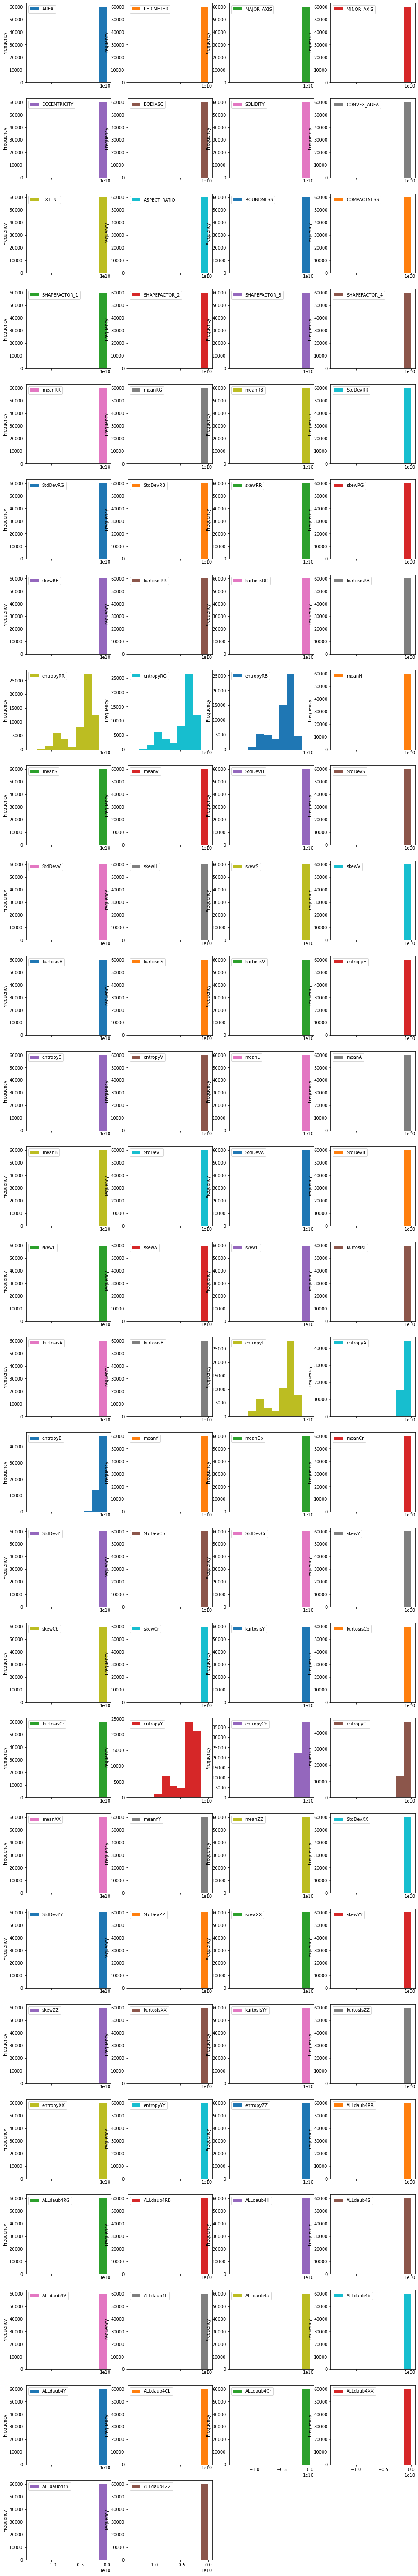

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

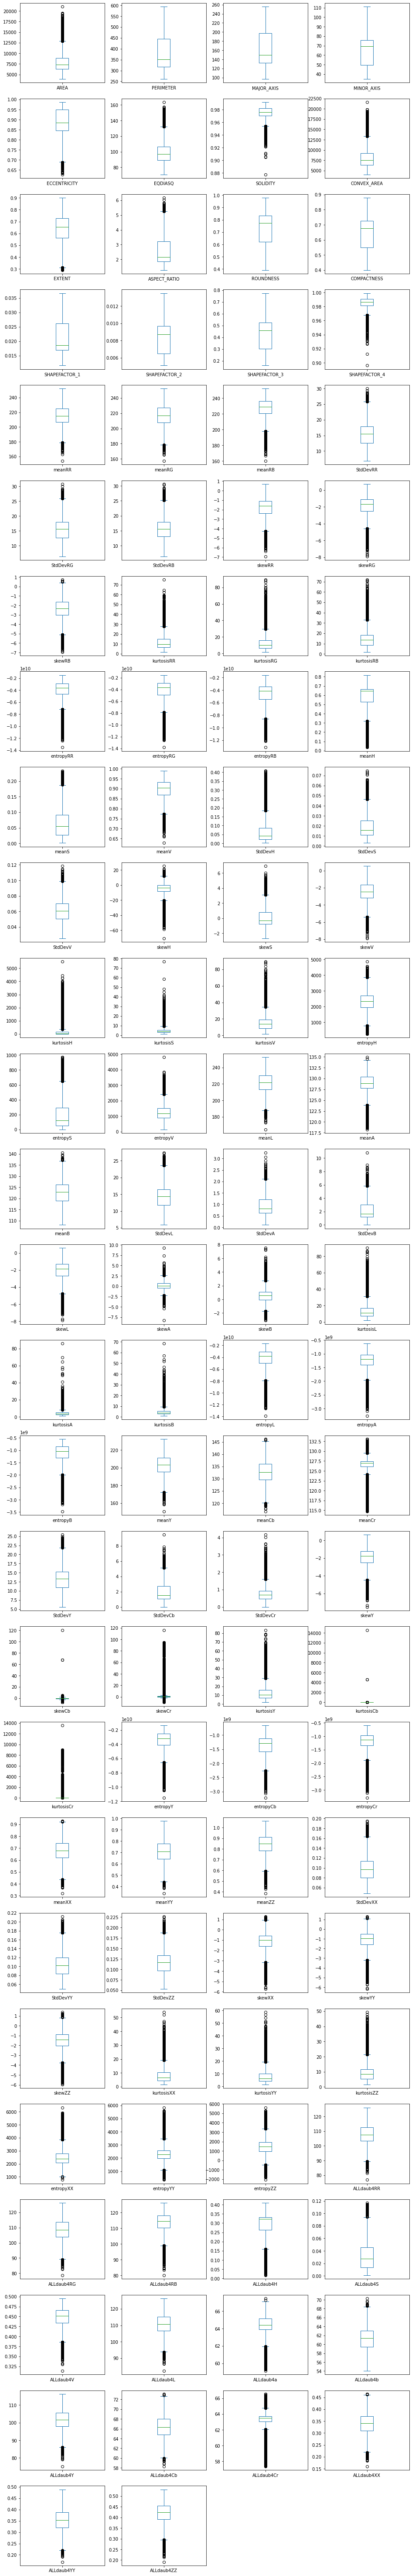

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [25]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [28]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 106
Number of categorical columns: 0
Total number of columns in the feature dataframe: 106


In [29]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (60000, 106) to array_features_train.shape: (60000, 106)


### 3.b) Training Data Balancing

In [30]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [31]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [32]:
# Finalize the training dataset for the modeling activities
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (60000, 106) array_target_train.shape: (60000,)


In [33]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [34]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [35]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [36]:
train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [37]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LDA: 0.997667 (0.000183)
LinearDiscriminantAnalysis()
Model training time: 0:00:04.744714 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   20.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: 0.995333 (0.000247)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:20.581240 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KNN: 0.997983 (0.000193)
KNeighborsClassifier(n_jobs=2)
Model training time: 0:01:02.885778 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   59.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


BGT: 0.996967 (0.000670)
BaggingClassifier(n_jobs=2, random_state=888)
Model training time: 0:00:59.126233 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   55.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: 0.998650 (0.000111)
RandomForestClassifier(n_jobs=2, random_state=888)
Model training time: 0:00:55.825142 

EXT: 0.998683 (0.000276)
ExtraTreesClassifier(n_jobs=2, random_state=888)
Model training time: 0:00:10.359499 

Average metrics (accuracy) from all models: 0.9975472222222223
Total training time for all models: 0:03:33.542604


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   10.3s finished


### 4.b) Spot-checking baseline algorithms

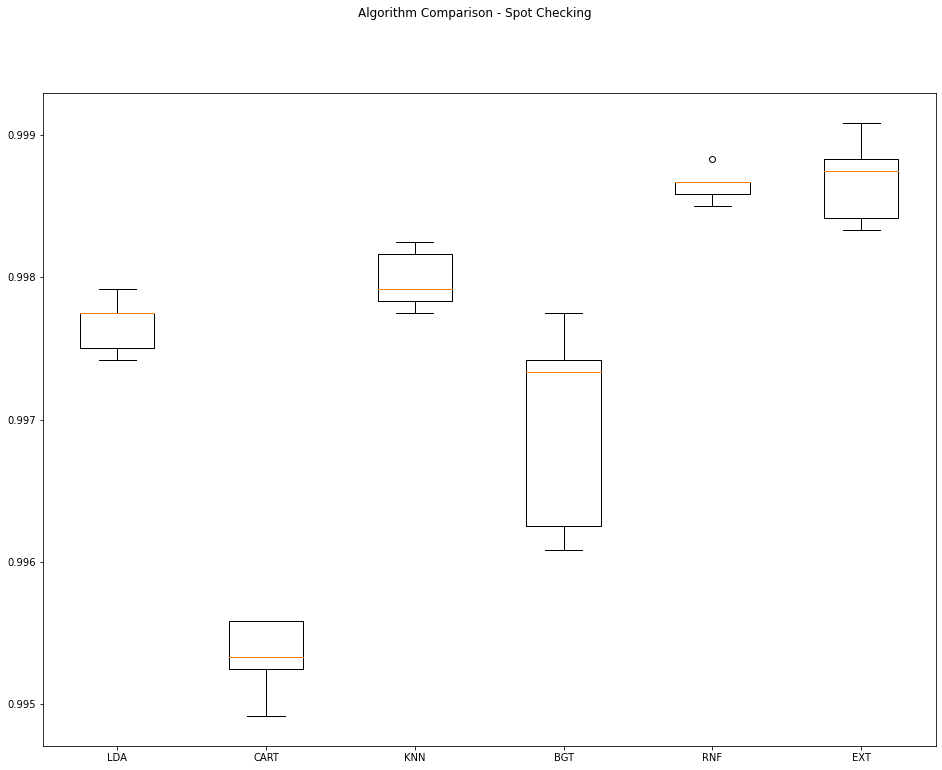

In [38]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Algorithm Tuning

In [40]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [41]:
# Tuning algorithm #1
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = KNeighborsClassifier(n_jobs=N_JOBS)
tune_model_names.append('KNN')
paramGrid1 = dict(n_neighbors=np.array([5, 7, 9]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.997983 using {'n_neighbors': 5}
0.997983 (0.000193) with: {'n_neighbors': 5}
0.997967 (0.000113) with: {'n_neighbors': 7}
0.997900 (0.000133) with: {'n_neighbors': 9}
Model training time: 0:02:51.826900


In [42]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_neighbors = 5


In [43]:
# Tuning algorithm #2
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('EXT')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.998733 using {'n_estimators': 500}
0.998683 (0.000276) with: {'n_estimators': 100}
0.998733 (0.000238) with: {'n_estimators': 300}
0.998733 (0.000226) with: {'n_estimators': 500}
Model training time: 0:01:41.567261


In [44]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 500


### 4.d) Compare Algorithms After Tuning

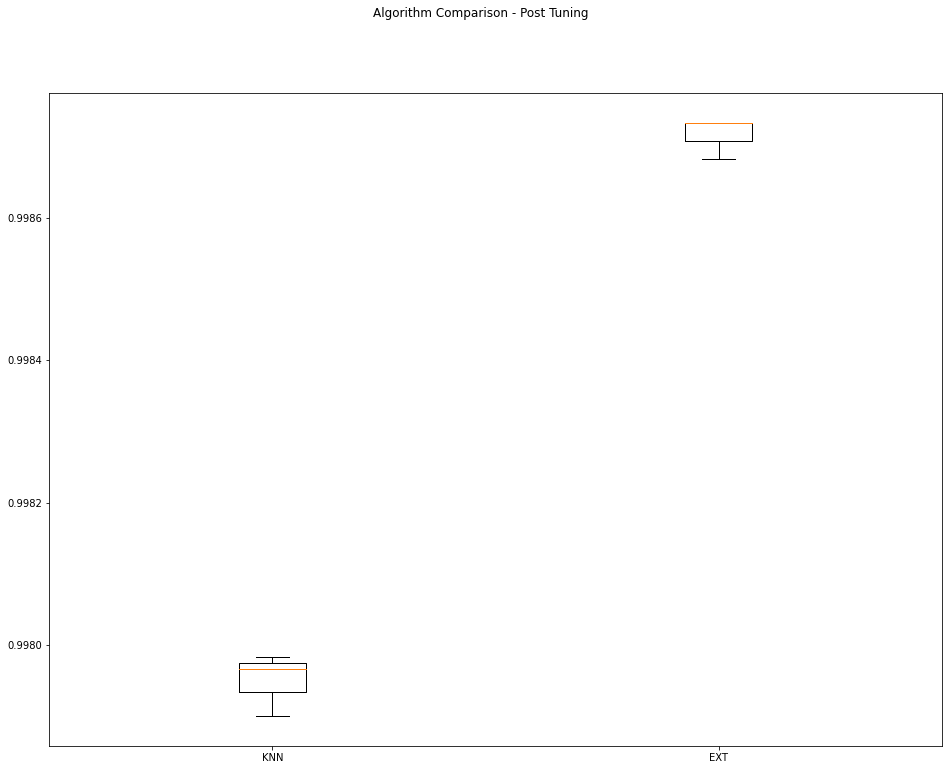

In [45]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [46]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [48]:
final_model = ExtraTreesClassifier(n_estimators=best_paramValue2, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

ExtraTreesClassifier(n_estimators=500, n_jobs=2, random_state=888)


### 5.b) Load Test Dataset and Make Predictions

In [49]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = label_encoder.fit_transform(df_target_test)
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (15000, 106) array_target_test.shape: (15000,)


In [50]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[3 4 0 ... 4 4 3]


In [51]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions), '\n')
print(confusion_matrix(array_target_test, test_predictions), '\n')
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.999 

[[3061    0    0    5    4]
 [   0 2949    0    2    0]
 [   0    0 2979    0    0]
 [   2    1    0 3039    0]
 [   1    0    0    0 2957]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3070
           1       1.00      1.00      1.00      2951
           2       1.00      1.00      1.00      2979
           3       1.00      1.00      1.00      3042
           4       1.00      1.00      1.00      2958

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [52]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:08:59.269829
